# Check probe location

**brief**:

* `30,190` cells (single-column microcircuit) with simulated activity
* `1,090` cells w/n a 50 um radius of the contacts of the two central shanks

**Predictions**:

- The two central shanks cover the microcircuit and should record lots of activity, while other shanks do not and should not cover much.


## Setup

Setup Jupyter notebook's kernel based on python env setup with `requirements_silico.txt` (see comments in file for setup)

In [1]:
# SET PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pprint as pp
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as spost
from probeinterface.plotting import plot_probe
from datetime import datetime
import pandas as pd
import h5py
nsites = 128

pd.set_option('display.max_colwidth', None)

# SET PATHS
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"

os.chdir(PROJ_PATH)
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico import loading_raw_recording  # TODO: add to loading module
from src.nodes.prepro import preprocess
from src.nodes.utils import get_config
from src.nodes.dataeng.silico.filtering import filter_microcircuit_cells
from src.nodes.utils import write_metadata
from src.nodes.dataeng.silico import probe_wiring
from src.nodes import viz 


# SET PARAMETERS
EXPERIMENT = "supp/silico_reyes"    # specifies the experiment 
SIMULATION_DATE = "2023_01_13" # specifies the run (date)


# SETUP CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET OUTPUT FIGURE PATHS
FIG_PATH = data_conf["figures"]["silico"]["probe_location"]

2023-03-22 14:43:36,694 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-22 14:43:36,760 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Target the microcircuit (30K cells)

(See 3)

In [2]:
# load campaign parameters
simulation = load_campaign_params(data_conf)

# count the circuit cells
print("Cell (count):", simulation["circuit"].cells.count())

# get the soma positions of our target neurons
filtered = filter_microcircuit_cells(simulation)
print("Cell (count): ", len(filtered["soma_location"]))
print("Preview of soma locations:")
filtered["soma_location"].head(3)

# Describe our target cells (see 1)
print("Cell ids:", filtered["gid"], "\n")

# List other available cell group (see 1)
print("Other available target groups:\n\n", sorted(simulation["circuit"].cells.targets))

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_silico/lib/python3.9/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_silico/lib/python3.9/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_silico/lib/python3.9/site-packages/nptyping/typing_.py:66: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  Int0 = np.int0
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_silico/lib/python3.9/site-packages/nptyping/typing_.py:80: DeprecationWarning: `np.uint0` is a deprecated alias for `np.uin

Cell (count): 4234929
Cell (count):  30190
Preview of soma locations:
Cell ids: [    301     335     381 ... 4234649 4234716 4234804] 

Other available target groups:

 ['All', 'AllCompartments', 'BC', 'BP', 'BP_BTC_DBC', 'BTC', 'CHC', 'DBC', 'DISTAR_INH', 'Efferents', 'Excitatory', 'Inh_not_LBC_NBC', 'Inhibitory', 'L1_DAC', 'L1_HAC', 'L1_LAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SAC', 'L23_BP', 'L23_BTC', 'L23_CHC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NBC_LBC', 'L23_NGC', 'L23_SBC', 'L2_IPC', 'L2_TPC:A', 'L2_TPC:B', 'L2_TPC_A', 'L2_TPC_B', 'L3_TPC:A', 'L3_TPC:C', 'L3_TPC_A', 'L3_TPC_C', 'L4_BP', 'L4_BTC', 'L4_CHC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_SBC', 'L4_SSC', 'L4_TPC', 'L4_UPC', 'L5_BC', 'L5_BP', 'L5_BTC', 'L5_CHC', 'L5_DBC', 'L5_LBC', 'L5_MC', 'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_TPC:A', 'L5_TPC:B', 'L5_TPC:C', 'L5_TPC_A', 'L5_TPC_AB', 'L5_TPC_B', 'L5_TPC_C', 'L5_TPC_C_UPC', 'L5_UPC', 'L6_BP', 'L6_BPC', 'L6_BTC', 'L6_CHC', 'L6_DBC', 'L6_HPC', 'L6_IPC', 'L6_

## Target cells near contacts

- w/n 50 um radius of the contacts

In [3]:
# get ground truth SpikeInterface Sorting Extractor object (stats: 2 min for 1221 cells)
SortingObject = ground_truth.run(simulation, data_conf, param_conf)
SortingObject = SortingObject["ground_truth_sorting_object"]

# count near-contact cells
unit_count = SortingObject.get_num_units()
print("Cells (count): ", unit_count)

# get their coordinates
sorted_cell_location = simulation["circuit"].cells.get(
    SortingObject.unit_ids, properties=["x", "y", "z"]
)
print("Preview of cells location:")
sorted_cell_location

2023-03-22 14:45:19,280 - root - ground_truth.py - create_sorting_object - INFO - Creating and writing SpikeInterface's Sorting extractor object...
Cells (count):  1221
Preview of cells location:


,x,y,z
10250,4158.050846,-1219.555411,-2132.907011
20590,4139.025903,-1199.826450,-2084.926730
47971,4115.412188,-1228.483047,-2112.379348
48718,4129.859202,-1425.683952,-2065.655541
49465,4210.612149,-1272.236149,-2054.773557
...,...,...,...
4209762,3741.934039,-1308.830111,-2658.231898
4210736,3927.129609,-1136.287950,-2424.078933
4215563,3847.930193,-1170.078542,-2539.467473
4227733,3900.628294,-1377.737470,-2438.491164


## Replicate probe from source code

In [4]:
# wire preprocessed recording with probe and write to file
recording = probe_wiring.run_reyes_8_x_16(data_conf, param_conf)
probe_wiring.write(recording, data_conf)

# get probe coordinates
probe = recording.get_probe()
probe_coord = probe.contact_positions.astype(float)

write_binary_recording with n_jobs = 1 and chunk_size = None
2023-03-22 14:45:40,340 - root - probe_wiring.py - write - INFO - Probe wiring done in  4.5 secs
2023-03-22 14:45:40,342 - root - probe_wiring.py - write - INFO - Probe wiring done in  4.5 secs
2023-03-22 14:45:40,344 - root - probe_wiring.py - write - INFO - Probe wiring done in  4.5 secs


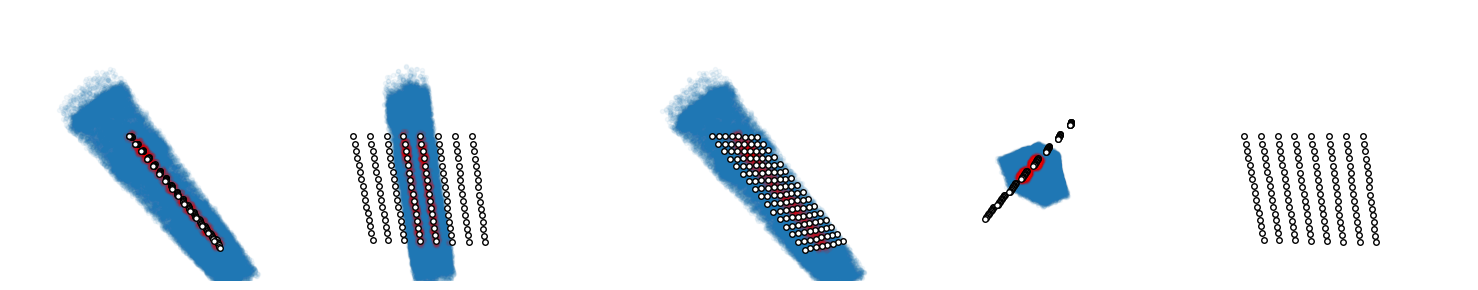

In [16]:
# plot probe with microcircuit and cell with 50 microns of the contacts
fig_01 = viz.plot_probe_with_circuit(
    cell_coord=filtered["soma_location"],
    target_cell_coord=sorted_cell_location,
    probe_coord=probe_coord,
    contact_ids=probe.device_channel_indices,
)

### Validate that the result holds with the associated channel weights

The weight file of the Reyes Puerta probe that Joseph Tharayil has re-created on February 24th have changed. The previous one matched perfectly the plot above.
TODO: 
The current fix is `'/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/lfpNeuron/L5/identical/stim/4fb3dd1c-4bd6-40ef-8aa2-5f410550ba66/000/testNew/coeffsFull/reyespuertacolumns/coeffsreyespuertaFull.h5'`


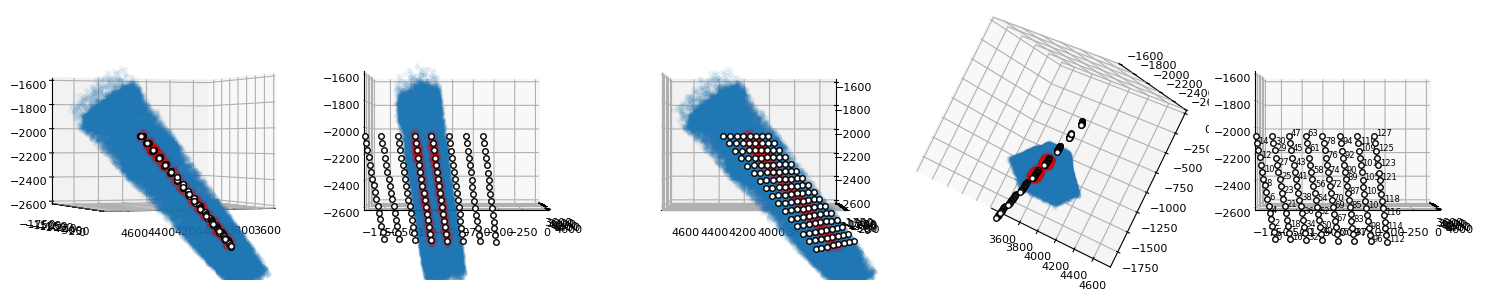

In [65]:
N_CHANNELS = 128
# weightspath ='/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/coeffsreyespuerta.h5'
# weightspath = '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/lfpNeuron/L5/identical/stim/4fb3dd1c-4bd6-40ef-8aa2-5f410550ba66/000/testNew/coeffsFull/reyespuertacolumns/coeffsreyespuertaFull.h5'
weightspath = "/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/lfpNeuron/L5/identical/stim/4fb3dd1c-4bd6-40ef-8aa2-5f410550ba66/000/testNew/coeffsFull/reyespuertacolumns/coeffsreyespuerta.h5"
PLOT_DIM = 3

# load simulated recording sites coordinates
f = h5py.File(weightspath, "r")
locationstmp = np.array([0, 0, 0])
contact_ids = []

N_CHANNELS = len(f["electrodes"].keys())

for c_i in range(1, N_CHANNELS):

    # temp = np.array(f["electrodes"]["reyespuerta_" + str(i)]["location"])
    # get contact ids from the weight file
    contact_id = str(list(f["electrodes"].keys())[c_i][len("reyespuerta_") :])
    contact_ids.append(contact_id)

    # get the contacts' coordinates
    temp = np.array(f["electrodes"]["reyespuerta_" + contact_id]["location"])
    locationstmp = np.c_[locationstmp, temp]

contact_coords = locationstmp.T[1:]
contact_ids = np.array(contact_ids)

# plot probe with microcircuit and cell within 50 microns of the contacts
fig_02 = viz.plot_probe_with_circuit(
    cell_coord=filtered["soma_location"],
    target_cell_coord=sorted_cell_location,
    probe_coord=contact_coords,
    contact_ids=contact_ids,
)

# WRITE

In [64]:
# save figure
fig_01.savefig(FIG_PATH + ".png")

# write metadata
metadata = {
    "fig_path": FIG_PATH,
    "creation_date": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
    "simulation_date": SIMULATION_DATE,
    "data_conf": data_conf,
    "param_conf": param_conf,
}
write_metadata(metadata, FIG_PATH)

# References

(1) https://bbpgitlab.epfl.ch/nse/bluepy/-/blob/main/examples/ipython_notebooks/Usecase%201%20-%20Selecting%20cells%20from%20a%20circuit.ipynb 

(2) https://bbpteam.epfl.ch/documentation/projects/bluepy/latest/index.html 

(3) https://bbpteam.epfl.ch/documentation/projects/bluepy/latest/circuit.html 